In [1]:
%matplotlib inline
import cv2
import numpy as np
from image_pipeline import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import pickle
import os
import math

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

In [2]:
# Read in cars and notcars
images = glob.glob('training_data/vehicles/*/*.png')
cars = []
for image in images:
    cars.append(image)
images = glob.glob('training_data/non-vehicles/*/*.png')
notcars = []
for image in images:
    notcars.append(image)

sample_size = 10000
random_idx = np.random.randint(0, len(cars), min(len(cars),sample_size))
cars = np.array(cars)[random_idx]
notcars = np.array(notcars)[random_idx]
print("Number of cars: {}\nNumber of non-cars: {}".format(len(cars), len(notcars)))

Number of cars: 8792
Number of non-cars: 8792


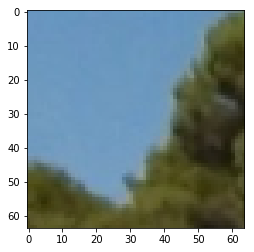

In [3]:
plt.imshow(mpimg.imread(notcars[0]))

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec,
                                  block_norm='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec,
                       block_norm='L2-Hys')
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
# Tried using only the saturation without avail
#     channel1_hist = np.histogram(cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2], bins=nbins)
#     return channel1_hist[0]


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,
                        vis=False):
    #1) Define an empty list to receive features
    img_features = []
    img_hogs = []
    
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            if vis == True:
                hog_images = []
                for channel in range(feature_image.shape[2]):
                    hf, hi = get_hog_features(feature_image[:,:,channel], 
                                              orient, pix_per_cell, cell_per_block, 
                                              vis=True, feature_vec=True)
                    hog_features.extend(hf)
                    hog_images.extend(hi)
            else:
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
#             print("chs: {}, orient: {}, pix_per_cell: {}, cell_per_block: {}".format(feature_image.shape[2], orient,
#                                                                                      pix_per_cell, cell_per_block))
        else:
            if vis == True:
                hog_features, hog_images = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
        try:
            img_hogs.append(hog_images)
        except:
            pass
    
#     print(spatial_features.shape)
#     print(hist_features.shape)
#     print(len(hog_features))
#     print(np.concatenate(img_features).shape)
    #9) Return array of features
    if vis == True:
        return (np.concatenate(img_features), img_hogs)
    else:
        return np.concatenate(img_features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        file_features = single_img_features(image, color_space=color_space, spatial_size=spatial_size,
                                            hist_bins=hist_bins, orient=orient, 
                                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=False)
        features.append(file_features)
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

(96,)


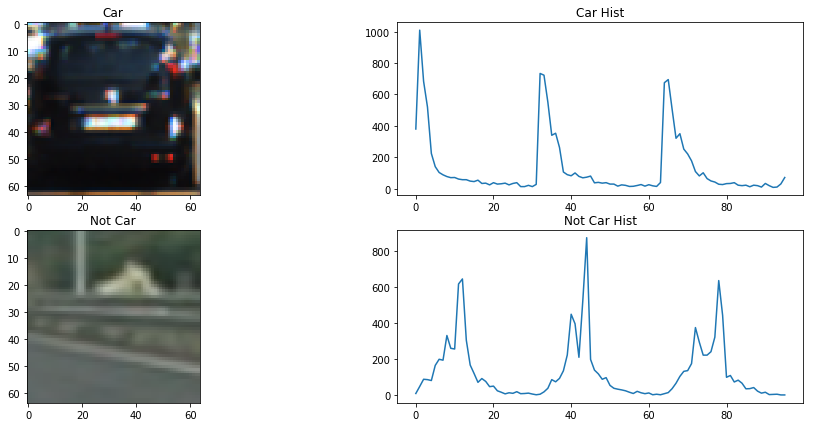

In [5]:
idx = np.random.randint(0, len(cars))
car_img = mpimg.imread(cars[idx])
car_spt = color_hist(car_img)
idx = np.random.randint(0, len(notcars))
notcar_img = mpimg.imread(notcars[idx])
notcar_spt = color_hist(notcar_img)
print(car_spt.shape)

fig = plt.figure(figsize=(16,7))
plt.subplot(221)
plt.imshow(car_img)
plt.title("Car")
plt.subplot(222)
plt.plot(car_spt)
plt.title("Car Hist")
plt.subplot(223)
plt.imshow(notcar_img)
plt.title("Not Car")
plt.subplot(224)
plt.plot(notcar_spt)
plt.title("Not Car Hist")

# 1. HOG

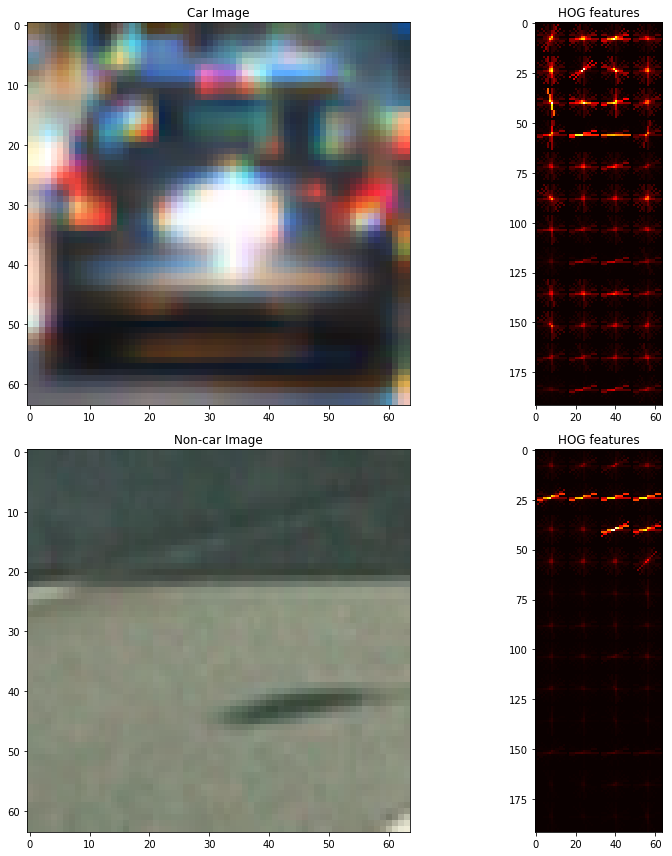

In [6]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

idx = np.random.randint(0, len(cars))
img = mpimg.imread(cars[idx])
car_features, car_hog_images = single_img_features(
    img, color_space=color_space, spatial_size=spatial_size,
    hist_bins=hist_bins, orient=orient, 
    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,
    vis=True)


fig = plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(img)
plt.title('Car Image')
plt.subplot(222)
plt.imshow(car_hog_images[0], cmap='hot')
plt.title('HOG features')

idx = np.random.randint(0, len(notcars))
img = mpimg.imread(notcars[idx])
car_features, car_hog_images = single_img_features(
    img, color_space=color_space, spatial_size=spatial_size,
    hist_bins=hist_bins, orient=orient, 
    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,
    vis=True)

plt.subplot(223)
plt.imshow(img)
plt.title('Non-car Image')
plt.subplot(224)
plt.imshow(car_hog_images[0], cmap='hot')
plt.title('HOG features')
fig.tight_layout()

# 2. Sliding Window

In [7]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

## 2.1. Training the classifier

In [8]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score

CLF_PICKLE = 'clf.pickle'
if os.path.isfile(CLF_PICKLE):
    clf = pickle.load(open(CLF_PICKLE, "rb"))
    X_scaler = clf['X_scaler']
    svc = clf['svc']
    print("classifier and scaler loaded")
else:
    print("Extracting features...")
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    t = time.time()
    print("Fitting scaler...")
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    
    clf = GridSearchCV(svc, {'C':[0.1, 1, 0.6]},
                       scoring='precision', n_jobs=2)
    clf.fit(X_train, y_train)
    svc = clf.best_estimator_
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    y_pred = svc.predict(X_test)
    print('Test Precision of SVC = ', precision_score(y_test, y_pred))

    clf_dict = {
        'svc': svc,
        'X_scaler': X_scaler
    }
    
    pickle.dump(clf_dict, open(CLF_PICKLE, "wb"))
    
print(svc)

classifier and scaler loaded
LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


## 2.2. Sliding window with one hog transformation on each patch

0.5834331512451172 seconds to process one image searching 100 windows
0.3880031108856201 seconds to process one image searching 100 windows
0.40360069274902344 seconds to process one image searching 100 windows
0.45567989349365234 seconds to process one image searching 100 windows
0.3990333080291748 seconds to process one image searching 100 windows
0.3846011161804199 seconds to process one image searching 100 windows
0.3925442695617676 seconds to process one image searching 100 windows
0.3792426586151123 seconds to process one image searching 100 windows
0.3544750213623047 seconds to process one image searching 100 windows


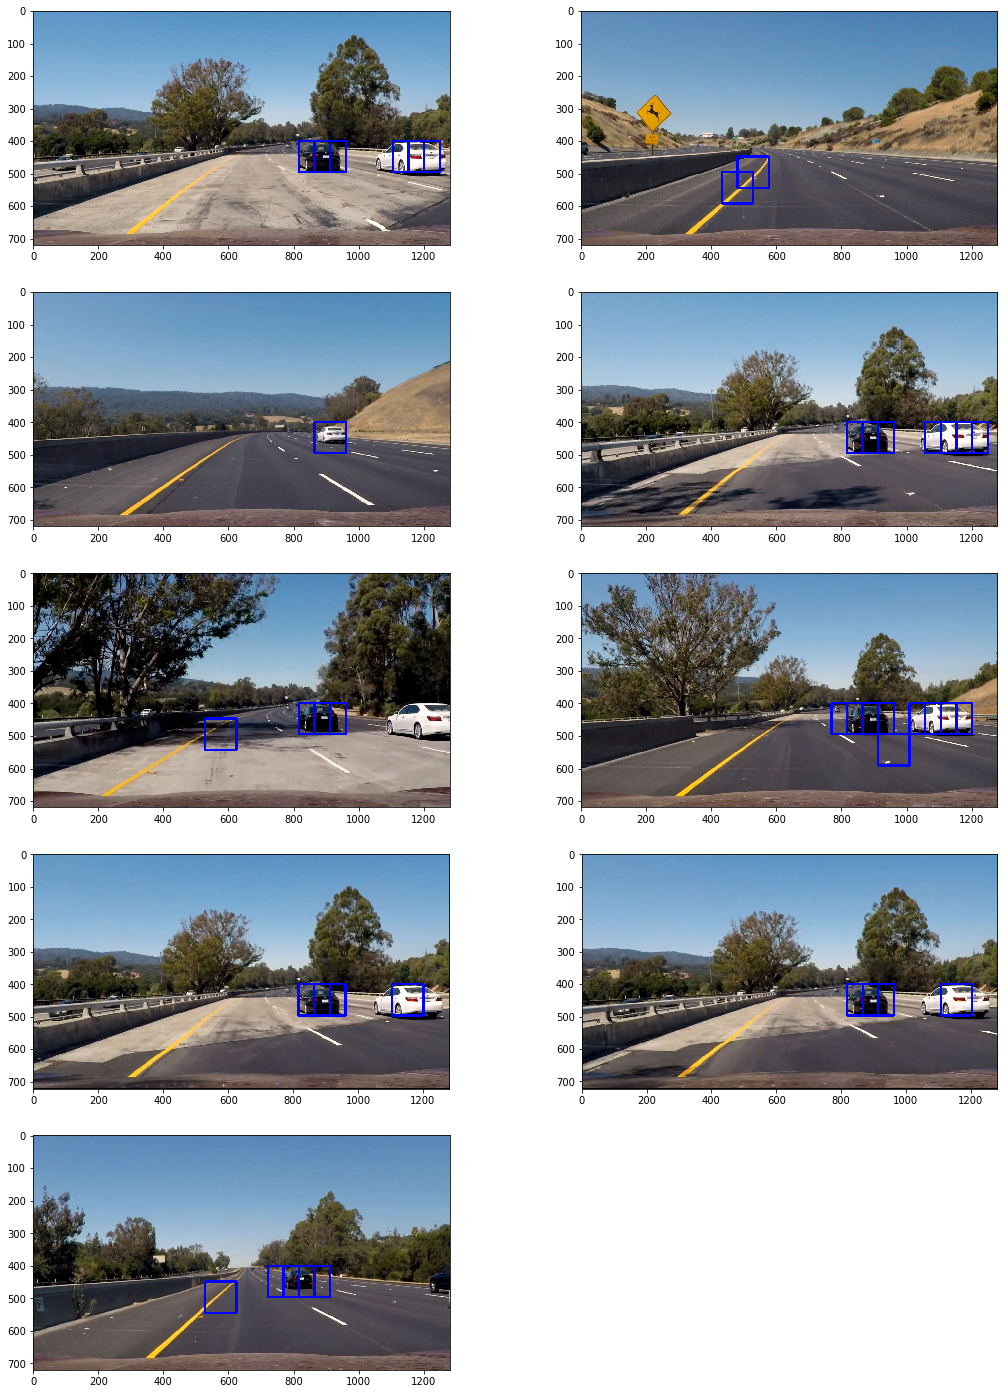

In [10]:
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
image_paths = glob.glob('test_images/*.jpg')

cols = 2
rows = math.ceil(len(image_paths)/cols)
fig = plt.figure(figsize=(18,5*rows))
c = 0

for image_path in image_paths:
    t1 = time.time()
    image = mpimg.imread(image_path)
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                 spatial_size=spatial_size, hist_bins=hist_bins, 
                                 orient=orient, pix_per_cell=pix_per_cell, 
                                 cell_per_block=cell_per_block, 
                                 hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                 hist_feat=hist_feat, hog_feat=hog_feat)                       

    print("{} seconds to process one image searching {} windows".format(time.time() - t1, len(windows)))
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    a = fig.add_subplot(rows, cols, c+1)
    _=plt.imshow(window_img)
    c += 1

## 2.3. Hog the entire image, then split into patches

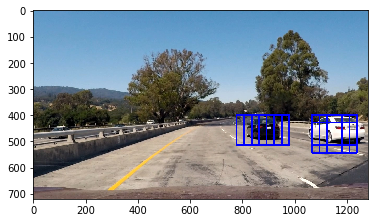

In [11]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

cells_per_step = 1  # Instead of overlap, define how many cells to step

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell,
              cell_per_block, spatial_size, hist_bins, img_type='png',
              hog_channel=1, bbox_list=None, color_space='YUV', cells_per_step=cells_per_step):        

    draw_img = np.copy(img)
    if bbox_list is None:
        bbox_list = []
    else:
        for bbox in bbox_list:
            cv2.rectangle(draw_img,*bbox,(0,0,255),6) 

    if img_type in ('png'):
        img = img.astype(np.float32)/255
    elif img_type in ('jpg', 'jpeg'):
        pass
    img_tosearch = img[ystart:ystop,:,:]
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)
        
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    chs = [
        ctrans_tosearch[:,:,0],
        ctrans_tosearch[:,:,1],
        ctrans_tosearch[:,:,2]
    ]

    # Define blocks and steps as above
    nxblocks = (chs[0].shape[1] // pix_per_cell)-1
    nyblocks = (chs[0].shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hogs = []
    for i in range(3):
        if hog_channel == i or hog_channel == 'ALL':
            hog_f = get_hog_features(chs[i], orient, pix_per_cell, cell_per_block, feature_vec=False, vis=False)
            hogs.append(hog_f)
#     print("chs: {} orient: {} pix_per_cell: {}, cell_per_block: {}".format(len(chs), orient, pix_per_cell, cell_per_block))
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feats = []
            for i in range(len(hogs)):
                hog_feats.append(hogs[i][ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel())
            hog_features = np.hstack(hog_feats)
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            train_img_width_px = 64
            train_img_height_px = 64
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (train_img_width_px,train_img_height_px))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)


            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                bbox_list.append(bbox)
                cv2.rectangle(draw_img,*bbox,(0,0,255),6) 
                
    return (draw_img, bbox_list)
    
ystart = 400
ystop = 645
scale = 1.8

img = mpimg.imread('test_images/test1.jpg')

out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient,
                               pix_per_cell, cell_per_block, spatial_size, hist_bins,
                               hog_channel=hog_channel, color_space=color_space, cells_per_step=cells_per_step)

plt.imshow(out_img)

## 2.4. Multiple scales sliding window

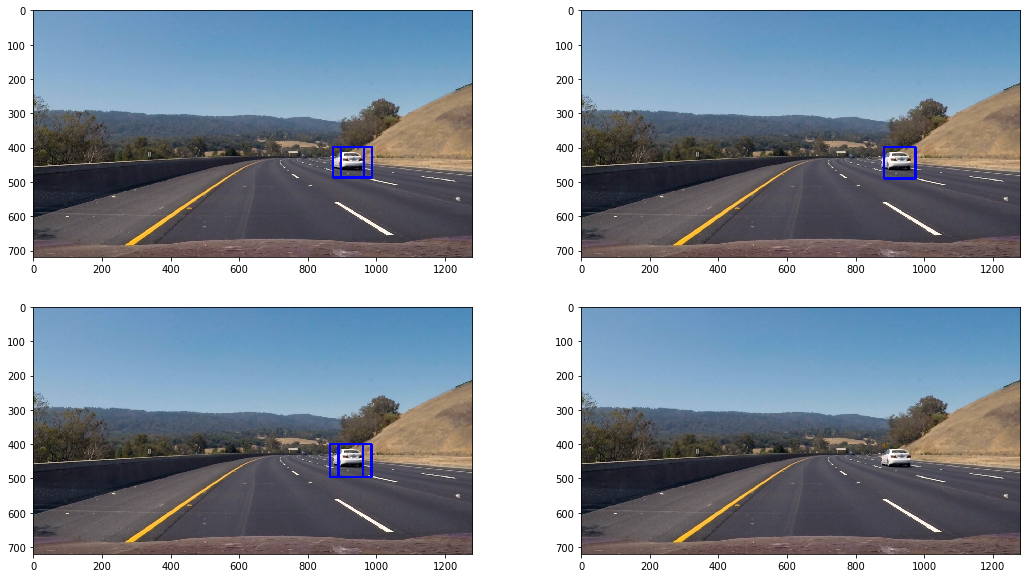

In [12]:
import math

ystart = 400
ystop = 645
scales = [1.4, 1.45, 1.5, 3]

img = mpimg.imread('test_images/test3.jpg')

cols = 2
rows = math.ceil(len(scales)/cols)
fig = plt.figure(figsize=(18,5*rows))
c = 0

for scale in scales:
    
    out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient,
                                   pix_per_cell, cell_per_block, spatial_size, hist_bins,
                                   hog_channel=hog_channel, color_space=color_space, cells_per_step=cells_per_step)
    a = fig.add_subplot(rows, cols, c+1)
    _=plt.imshow(out_img)
    c += 1

## 2.5. Combine the bboxes with heatmap

0.5893204212188721 seconds to process one image
0.6126570701599121 seconds to process one image
0.607614278793335 seconds to process one image
0.6001162528991699 seconds to process one image
0.544165849685669 seconds to process one image
0.5961189270019531 seconds to process one image
0.6021263599395752 seconds to process one image
0.5584862232208252 seconds to process one image
0.536578893661499 seconds to process one image


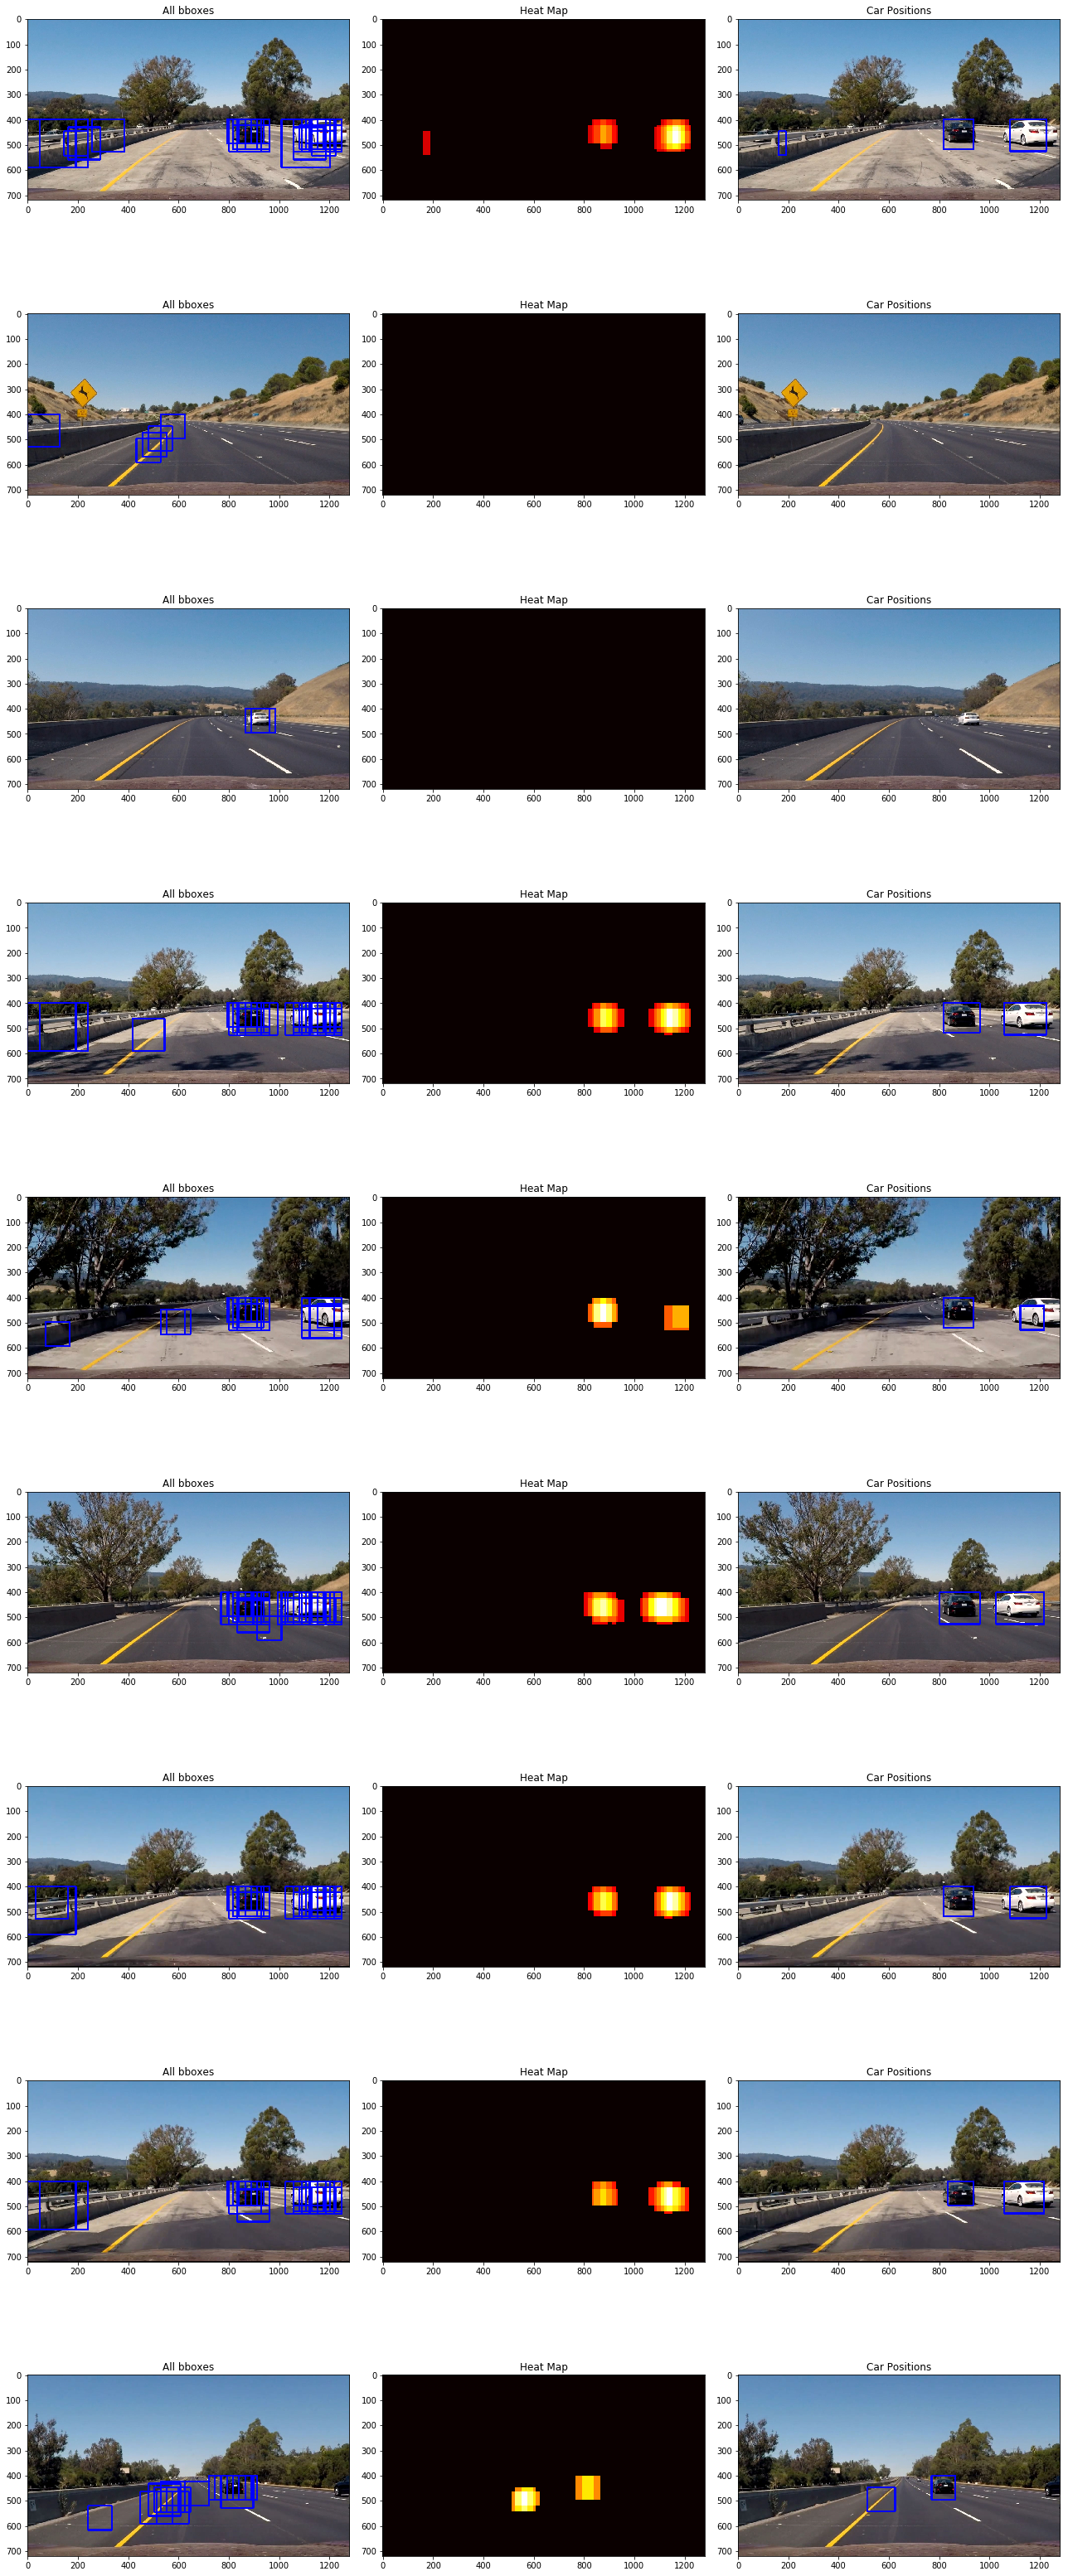

In [13]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

image_paths = glob.glob('test_images/*.jpg')
# image_paths = ['test_images/test9.jpg']

cols = 3
rows = len(image_paths)/cols*3
fig = plt.figure(figsize=(18,5*rows))
c = 0

n_threshold = 3
ystart = 400
ystop = 645
scales = [1.5, 2, 3]

# Update bbox_list for next frames
bbox_list = []

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels, return_bbox_list=False):
    bbox_list = []
    for bbox in bboxes_from_labels(labels):
        bbox_list.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    if return_bbox_list:
        return (img, bbox_list)
    else:
        # Return the image
        return img

def bboxes_from_labels(labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        yield(bbox)
    
for image_path in image_paths:
    image = mpimg.imread(image_path)
    image = cv2.resize(image, (1280, 720))
    t1 = time.time()
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    bbox_list = []
    for scale in scales:

        _, bbox_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient,
                                 pix_per_cell, cell_per_block, spatial_size, hist_bins,
                                 hog_channel=hog_channel, bbox_list=bbox_list, color_space=color_space,
                                 cells_per_step=cells_per_step)

    out_img = np.copy(image)
    for bbox in bbox_list:
        # Draw the box on the image
        cv2.rectangle(out_img, bbox[0], bbox[1], (0,0,255), 6)
        
    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, n_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img, bbox_list = draw_labeled_bboxes(np.copy(image), labels, return_bbox_list=True)

    a = fig.add_subplot(rows, cols, c+1)
    plt.imshow(out_img)
    plt.title('All bboxes')
    c += 1
    
    a = fig.add_subplot(rows, cols, c+1)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    c += 1
    print("{} seconds to process one image".format(time.time() - t1))

    a = fig.add_subplot(rows, cols, c+1)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    c += 1

fig.tight_layout()

# 3. Video

In [14]:
bbox_list = [[],[]]
bbox_all = []
frame_counter = 0
n_threshold = 6
def process_image(img):
    """
    Process every x frames
    """
    global bbox_list, n_threshold, frame_counter, bbox_all
    copy_img = np.copy(img)
    
    if frame_counter % 2 == 0:
        idx = 1
    else:
        idx = 0
    bbox_list[idx] = []
    for scale in scales:
        _, bbox_list[idx] = find_cars(copy_img, ystart, ystop, scale, svc, X_scaler, orient,
                                 pix_per_cell, cell_per_block, spatial_size, hist_bins,
                                 hog_channel=hog_channel, bbox_list=bbox_list[idx], color_space=color_space,
                                 cells_per_step=cells_per_step)
#         print("c1: {}".format(len(bbox_list[idx])))
    bbox_all.extend(bbox_list[idx])

#     print("frame counter = {}".format(frame_counter))
#     print("bbox count= {}".format(len(bbox_list[0]) + len(bbox_list[1])))
    heat = np.zeros_like(copy_img[:,:,0]).astype(np.float)

    heat = add_heat(heat,bbox_list[0] + bbox_list[1])

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, n_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(copy_img, labels)

    frame_counter += 1

#     for bbox in bbox_list:
#         # Draw the box on the image
#         cv2.rectangle(draw_img, bbox[0], bbox[1], (0,255, 0), 3)

#     text0 = "num of bbox: {}".format(len(bbox_list))
#     cv2.putText(draw_img, text0, (40, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), thickness=2)
    
    return draw_img

In [15]:
from moviepy.editor import VideoFileClip

bbox_list = [[],[]]
bbox_all = []
frame_counter = 0
test_output = 'test_video_processed.mp4'
clip = VideoFileClip('test_video.mp4')
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_video_processed.mp4
[MoviePy] Writing video test_video_processed.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:18<00:00,  1.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_processed.mp4 



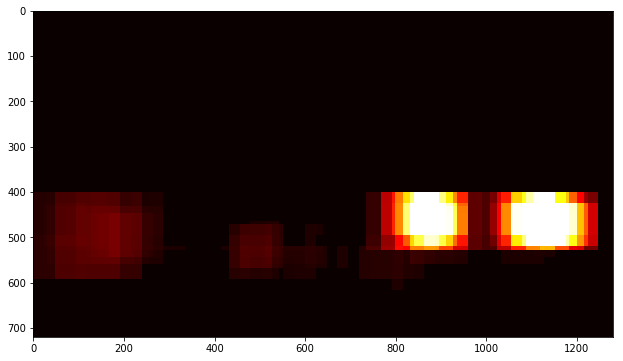

In [16]:
fig = plt.figure(figsize=(18,6))
heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = add_heat(heat,bbox_all)
heat = apply_threshold(heat, n_threshold)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
plt.imshow(heatmap, cmap='hot')
# _=plt.imshow(process_image(image))

In [17]:
bbox_list = [[],[]]
bbox_all = []
frame_counter = 0
test_output = 'project_video_processed.mp4'
clip = VideoFileClip('project_video.mp4')
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [10:44<00:00,  1.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 



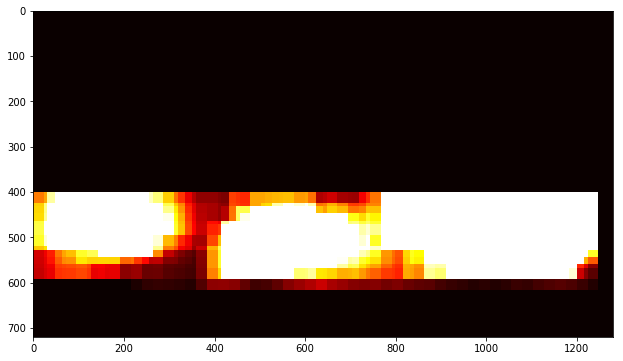

In [18]:
fig = plt.figure(figsize=(18,6))
heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = add_heat(heat,bbox_all)
heat = apply_threshold(heat, n_threshold)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
plt.imshow(heatmap, cmap='hot')
# _=plt.imshow(process_image(image))